In [1]:
import warnings
import sys
sys.path.append('../')

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix

import json
from TrainMLModels import make_folder, read_json, LogisticRegression

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

warnings.filterwarnings(action='ignore')

In [3]:
# datasets = ['cardio', 'bank', 'meps16', 'lsac'] #, 'ACSE', 'ACSP', 'ACSM', 'ACSI']
# seeds = [1, 12345, 6, 2211, 15]
# set_suffix = 'S_1'

# degree_df = pd.DataFrame(columns=['data', 'seed', 'method', 'degree', 'BalAcc', 'SPDiff'])
# for data_name in datasets:
#     cur_dir = 'intermediate/models/' + data_name +'/'
#     for seed in seeds:
#         for method, base in zip(['scc', 'scc', 'scc', 'omn'], ['one', 'kam', 'omn', 'one']):
#             f = open('{}degrees-{}-{}-{}.txt'.format(cur_dir, seed, method, base), "r")
#             while(True):
#                 line = f.readline()
#                 if not line:
#                     break
#                 cur_res = line.strip().replace('---', '').split(' ')
#                 degree_df.loc[degree_df.shape[0]] = [data_name, seed, method.upper()+'-'+base.upper(), float(cur_res[0]), float(cur_res[1]), float(cur_res[2])]
#         method = 'kam'
#         base = 'one'
#         eval_res = read_json('{}eval-{}-{}-{}-{}.json'.format(cur_dir, seed, set_suffix, method, base))
#         acc = eval_res[method.upper()]['all']['BalAcc']
#         sp = eval_res[method.upper()]['all']['SPDiff']
#         for degree_i in [x/100 for x in range(1, 201)]:
#             degree_df.loc[degree_df.shape[0]] = [data_name, seed, method.upper()+'-'+base.upper(), degree_i, acc, sp]
# degree_df.to_csv('intermediate/evals/Degree_data4_n5.csv', index=False)        

In [12]:
data_name = 'ACSH'

repo_dir = sys.path[0].replace('notebooks', '')
eval_path=repo_dir+ 'eval/'

degree_df = pd.read_csv('{}degree-{}.csv'.format(eval_path, data_name))
degree_df.head()

,data,model,seed,method,degree,BalAcc,SPDiff
0,ACSH,LR,1,KAM-ONE,0.01,0.611788,-0.019881
1,ACSH,LR,1,KAM-ONE,0.02,0.611788,-0.019881
2,ACSH,LR,1,KAM-ONE,0.03,0.611788,-0.019881
3,ACSH,LR,1,KAM-ONE,0.04,0.611788,-0.019881
4,ACSH,LR,1,KAM-ONE,0.05,0.611788,-0.019881


In [13]:
degree_df.query('method == "OMN-ONE"').head()

,data,model,seed,method,degree,BalAcc,SPDiff


In [14]:
degree_df['method'].unique()

array(['KAM-ONE', 'CAP-ONE'], dtype=object)

In [4]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x, name):
    if 'Diff' in name: # difference change to 1-abs(x)
        return 1-abs(x)
    
    elif name == 'DI':
        if x > 1:
            return min(x, 1/x)
        else:
            return x
    else:# other metrics
        return x
def add_vis_flag(x, name):
    if 'Diff' in name: # difference change to 1-abs(x)
        if name in ['ERRDiff', 'FNRDiff', 'FPRDiff']: # measures with lower value means better
            if x > 0: 
                return 0
            else: # G0 has better outcome
                return 1
        else: # for measures like eqdiff, avgoddsdiff, spdiff with higher value means better
            if x < 0: 
                return 0
            else: # G0 has better outcome
                return 1
    
    elif name == 'DI':
        if x > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [5]:
def scatter_plots(df, output_name, vis_metric, vis_methods, legend_names, font_label=10, font_legend=18, 
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d'], marks=['^', 's', 'o', 'D'], 
              bg_color = '#f3f3f3', 
              x_values=None, y_label=None, x_label=None, legend=True, legend_col=4, save_to_disc=True):

    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    
#     vis_df = input_df[(input_df['data']==vis_dataset)]
    edge_colors = []
    for method_i, color_i, mark_i, legend_i in zip(vis_methods, colors, marks, legend_names):
        
        if method_i in ['KAM-ONE', 'CAP-ONE']:
            x_df = vis_df[(vis_df['method']==method_i) & (vis_df['degree']==0.01)]
            
            y_values = np.array(x_df[vis_metric])
            y_line = np.mean(y_values)
            
#             n_reverse = sum(np.array(x_df['norm_flag']))
#             if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
#                 y_linestyle = 'dashed'
#             else:
#                 y_linestyle = 'solid'
            edge_colors.append(None)
            ax.plot([-1, max(x_values)+1], [y_line, y_line], color=color_i, linewidth=1.5, label=legend_i, linestyle='solid')
        else:
            
            for x_i in x_values:
                x_df = vis_df[(vis_df['method']==method_i) & (vis_df['degree']==x_i)]
            
                y_values = np.array(x_df[vis_metric])
#                 if vis_metric == 'SPDiff':
#                     n_reverse = 0
#                     for y in y_values:
#                         if y < 0:
#                             n_reverse += 1
                    
                
# #                 n_reverse = sum(np.array(x_df['norm_flag']))
#                     if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
#                         edge_color = 'red'
#                     else:
#                         edge_color = 'black'
                    
#                     ax.scatter(x_i, np.mean(y_values), color=color_i, marker=mark_i, edgecolors=edge_color, s=95)
#                 else:
                ax.scatter(x_i, np.mean(y_values), color=color_i, marker=mark_i, edgecolors='black', s=95)
        
    for method_i, color_i, mark_i, legend_i in zip(vis_methods, colors, marks, legend_names):
        if method_i in ['KAM-ONE', 'CAP-ONE']:
            pass
        else:
            ax.scatter(-2, -1, color=color_i, marker=mark_i, s=95, edgecolors='black', label=legend_i)
#     # add line for KAM-CAL and CAP
#     if y_lines is not None:
#         for y_line, y_legend, y_color in zip(y_lines, y_legends, y_colors): #'#4166f5'
#             ax.plot([-1, max(x_ticks)+1], [y_line, y_line], color=y_color, linewidth=1.5, label=y_legend)

    
    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    
    plt.xlim([0.0, 2.01])
    plt.xticks([x for x in x_values if int(x*100)%10==0], fontsize=font_label)
    
    plt.ylim([-1.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label+10)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label+10)
    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label+10)

    if save_to_disc:
        plt.savefig(output_name, bbox_inches="tight")
        print('Scatter plot is saved at ', output_name)
        plt.close()

In [9]:

# exp_ticks = [x/100 for x in range(1, 201)]
plot_path = 'intermediate/plots/'
models = ['LR', 'TR']
exp_path = plot_path+'degree/'
make_folder(exp_path)

datasets = ['credit', 'cardio', 'meps16', 'lsac', 'bank'] #, 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']

eval_metrics = ['BalAcc', 'SPDiff']

for data_name in datasets:
    eval_df = pd.read_csv('intermediate/evals/degree-{}.csv'.format(data_name))

    methods = ['OMN-ONE', 'SCC-ONE', 'SCC-KAM', 'KAM-ONE']
    legends = ['OMN', 'SCC', 'SCC+K', 'KAM']
    colors = ['#fffacd', '#9dc209', '#2e8b57', '#f4ca16']
    markers = ['o', '^', 's', 'D']
    
    for model_name in models:
        if model_name == 'TR':
            methods = methods + ['CAP-ONE']
            legends = legends + ['CAP']
            colors = colors + ['#4166f5']
            markers = markers + ['T']
        vis_df = eval_df.query('model=="{}"'.format(model_name))
        exp_ticks = list(vis_df['degree'].unique())
#         print(vis_df['degree'].unique())
        for exp_metric in eval_metrics[:1]:
#             vis_df['norm_value'] = vis_df[exp_metric].apply(lambda x: normalize_fairness_measures(x, exp_metric))
#             vis_df['norm_flag'] = vis_df[exp_metric].apply(lambda x: add_vis_flag(x, exp_metric))
     
            
            output_file = '{}{}-{}-{}.png'.format(exp_path, data_name, model_name, exp_metric)
            scatter_plots(vis_df, output_file, exp_metric, methods, legends, colors=colors, legend_col=len(legends), 
                          x_values=exp_ticks, marks=markers,
                          x_label='intervention degree', y_label=exp_metric, save_to_disc=True)
    



Scatter plot is saved at  intermediate/plots/degree/credit-LR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/credit-TR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/cardio-LR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/cardio-TR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/meps16-LR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/meps16-TR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/lsac-LR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/lsac-TR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/bank-LR-BalAcc.png
Scatter plot is saved at  intermediate/plots/degree/bank-TR-BalAcc.png


In [27]:
exp_name = 'bank'

Scatter plot is saved at  intermediate/evals/plots/degree/bank_SPDiff.png


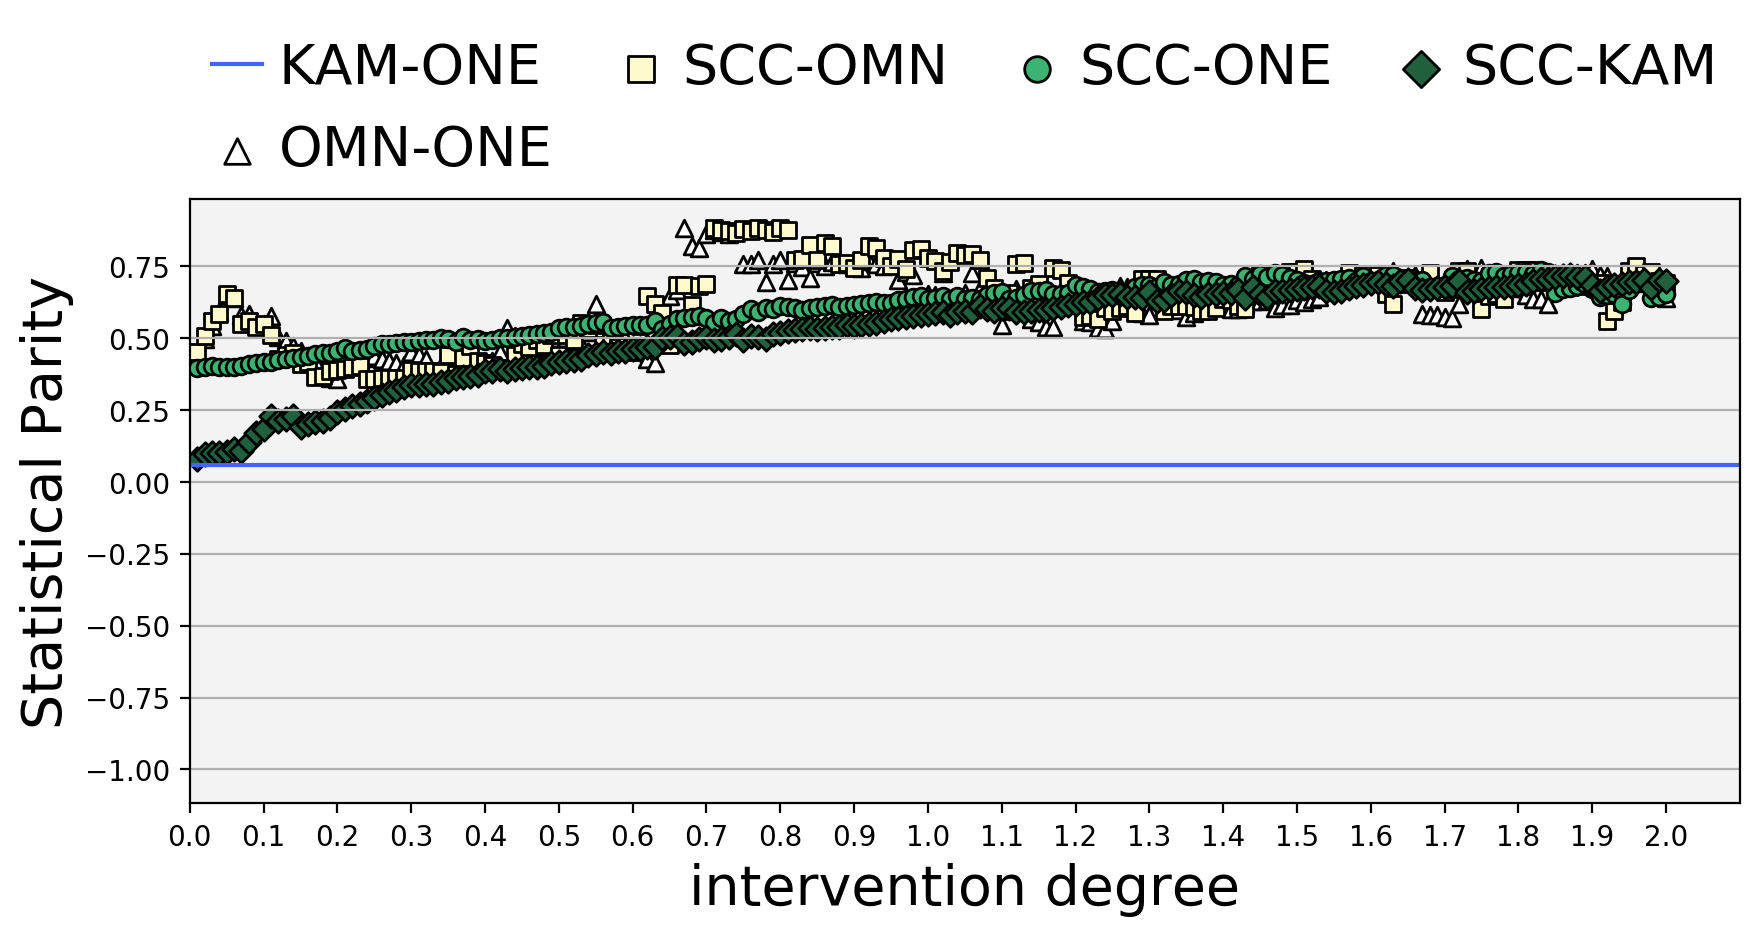

In [28]:
exp_metric = 'SPDiff'
kam_y = degree_df.query('method=="KAM-ONE" and data=="{}" and degree==0.01'.format(exp_name))[exp_metric].mean()

scatter_plots(degree_df, exp_name, exp_metric, methods, y_line=kam_y, x_ticks=exp_ticks, x_label='intervention degree', y_label='Statistical Parity')

Scatter plot is saved at  intermediate/evals/plots/degree/bank_BalAcc.png


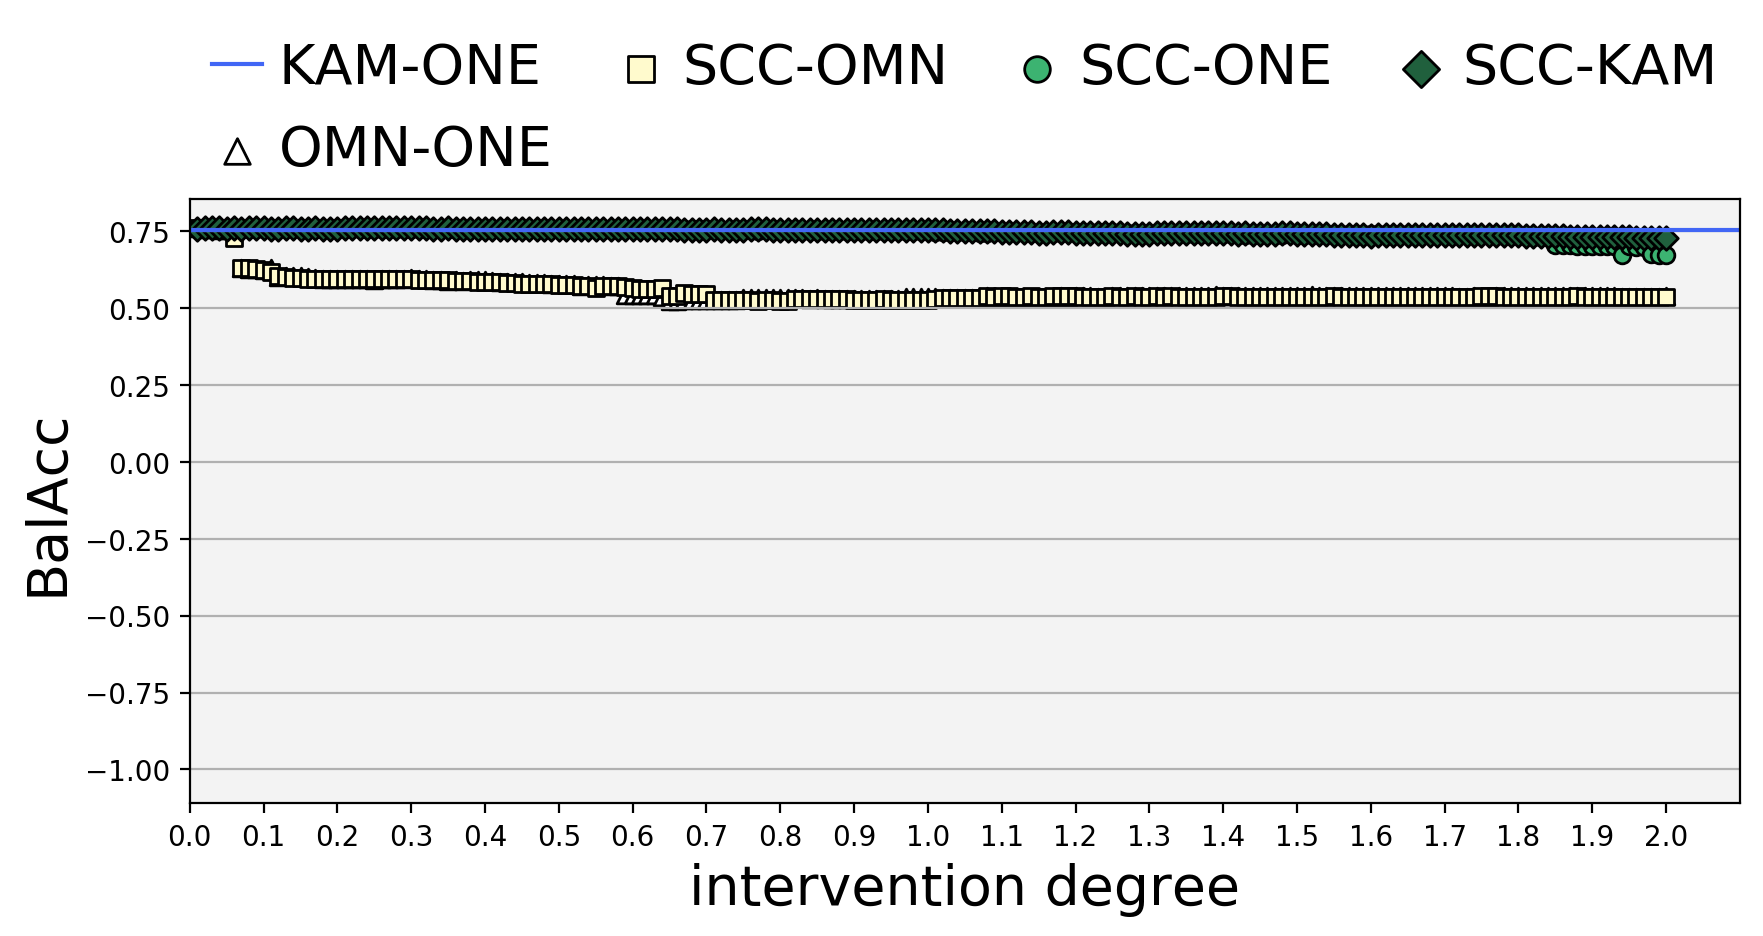

In [29]:
exp_metric = 'BalAcc'
kam_y = degree_df.query('method=="KAM-ONE" and data=="{}" and degree==0.01'.format(exp_name))[exp_metric].mean()

scatter_plots(degree_df, exp_name, exp_metric, methods, y_line=kam_y, x_ticks=exp_ticks, x_label='intervention degree', y_label=exp_metric)

In [3]:
def compute_sr(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    pred_P = TP+FP
    P = TP + FN
    N = TN + FP
    return pred_P / (P+N)

def eval_sp(test_eval_df, pred_col, sensi_col='A', n_groups=2):
    SR_all = []
    for group_i in range(n_groups):
        group_df = test_eval_df[test_eval_df[sensi_col] == group_i]
        group_sr = compute_sr(group_df['Y'], group_df[pred_col])
        SR_all.append(group_sr)

    sp_diff = SR_all[0] - SR_all[1]
    return sp_diff

def generate_model_predictions(cur_model, cur_data, opt_thres=None):
    pos_ind = np.where(cur_model.best_estimator_.named_steps['learner'].classes_ == 1.0)[0][0]
    Y_pred_proba = cur_model.predict_proba(cur_data)[:, pos_ind].reshape(-1, 1)

    if opt_thres is not None:
        return [int(y > opt_thres) for y in Y_pred_proba]
    else:
        return Y_pred_proba

def save_json(input_dict, file_path_with_name, verbose=True):
    with open(file_path_with_name, 'w') as json_file:
        json.dump(input_dict, json_file, indent=2)
    if verbose:
        print('--> Dict is saved to ', file_path_with_name + '\n')

def compute_weights(df, method, sample_base='zero', alpha_g0=2.0, alpha_g1=1.0, omn_lam=1.0, cc_col='vio_cc', sensi_col='A', y_col='Y'):

    group_1_y_1 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_1_y_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_0_y_1 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_0_y_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_1 = np.array(df[sensi_col] == 1).astype(int)
    group_0 = np.array(df[sensi_col] == 0).astype(int)
    target_1 = np.array(df[y_col] == 1).astype(int)
    target_0 = np.array(df[y_col] == 0).astype(int)
    group_1_y_1_vio_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 1).astype(int) * np.array(df[cc_col] == 0).astype(int)
    group_1_y_0_vio_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 0).astype(int) * np.array(df[cc_col] == 0).astype(int)
    group_0_y_1_vio_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 1).astype(int) * np.array(df[cc_col] == 0).astype(int)
    group_0_y_0_vio_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 0).astype(int) * np.array(df[cc_col] == 0).astype(int)

    total_n = df.shape[0]
    if method == 'scc':
        if sample_base == 'kam':
            sample_weights = np.zeros(total_n)

            sample_weights += group_1_y_1 * (np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))) \
                              + group_1_y_0 * (np.sum(group_1) * np.sum(target_0) / (total_n * np.sum(group_1_y_0))) \
                              + group_0_y_1 * (np.sum(group_0) * np.sum(target_1) / (total_n * np.sum(group_0_y_1))) \
                              + group_0_y_0 * (np.sum(group_0) * np.sum(target_0) / (total_n * np.sum(group_0_y_0)))
        elif sample_base == 'omn':
            sample_weights = np.ones(total_n)
            sample_weights -= omn_lam * total_n / np.sum(group_1) * group_1_y_1 \
                              - omn_lam * total_n / np.sum(group_1) * group_1_y_0 \
                              - omn_lam * total_n / np.sum(group_0) * group_0_y_1 \
                              + omn_lam * total_n / np.sum(group_0) * group_0_y_0

        elif sample_base == 'zero':
            sample_weights = np.zeros(total_n)
        elif sample_base == 'one':
            sample_weights = np.ones(total_n)
        else:
            raise ValueError('The input sample_base parameter is not supported. Choose from "[kam, omn, zero, one]".')

        sample_weights -= alpha_g1 * group_1_y_1_vio_0 \
                          - alpha_g1 * group_1_y_0_vio_0 \
                          - alpha_g0 * group_0_y_1_vio_0 \
                          + alpha_g0 * group_0_y_0_vio_0
    elif method == 'kam':
        sample_weights = np.zeros(total_n)

        sample_weights += group_1_y_1 * (np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))) \
                          + group_1_y_0 * (np.sum(group_1) * np.sum(target_0) / (total_n * np.sum(group_1_y_0))) \
                          + group_0_y_1 * (np.sum(group_0) * np.sum(target_1) / (total_n * np.sum(group_0_y_1))) \
                          + group_0_y_0 * (np.sum(group_0) * np.sum(target_0) / (total_n * np.sum(group_0_y_0)))
    elif method == 'omn':
        sample_weights = np.ones(total_n)
        sample_weights -= omn_lam * total_n / np.sum(group_1) * group_1_y_1 \
                          - omn_lam * total_n / np.sum(group_1) * group_1_y_0 \
                          - omn_lam * total_n / np.sum(group_0) * group_0_y_1 \
                          + omn_lam * total_n / np.sum(group_0) * group_0_y_0

    else:
        raise ValueError('The input method parameter is not supported. Choose from "[kam, omn, scc]".')

    return sample_weights

def compute_bal_acc(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    P = TP + FN
    N = TN + FP
    TPR = TP / P if P > 0.0 else np.float64(0.0)
    TNR = TN / N if N > 0.0 else np.float64(0.0)
    return 0.5 * (TPR + TNR)


def find_optimal_thres(y_val_df, opt_obj='BalAcc', num_thresh=100, verbose=False):
    ba_arr = np.zeros(num_thresh)
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

    for idx, class_thresh in enumerate(class_thresh_arr):
        y_val_df['Y_pred'] = y_val_df['Y_pred_scores'].apply(lambda x: x > class_thresh)
        if opt_obj == 'BalAcc':
            ba_arr[idx] = compute_bal_acc(y_val_df['Y'], y_val_df['Y_pred'])
        elif opt_obj == 'Acc':
            ba_arr[idx] = accuracy_score(y_val_df['Y'], y_val_df['Y_pred'])
        else:
            raise ValueError('The "opt_obj" specified is not supported. Now only support "BalAcc" and "Acc"!')
    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]
    if verbose:
        print("Best balanced accuracy = %.4f" % np.max(ba_arr))
        print("Optimal classification threshold = %.4f" % best_class_thresh)

    return {'thres': best_class_thresh, opt_obj: np.max(ba_arr)}




In [4]:
# def LR_trainer(data_name, seed, reweigh_method, weight_base, inter_high=10, res_path='../intermediate/models/',
#                verbose=False, set_suffix='S_1', data_path='../data/processed/', y_col = 'Y', sensi_col='A'):

#     cur_dir = res_path + data_name + '/'
#     make_folder(cur_dir)

#     train_df = pd.read_csv(cur_dir + '-'.join(['train_vio', str(seed)]) + '.csv')
#     validate_df = pd.read_csv(cur_dir + '-'.join(['val', str(seed), set_suffix]) + '.csv')

#     meta_info = read_json(data_path + data_name + '.json')
#     n_features = meta_info['n_features'] # including sensitive column

#     if set_suffix == 'S_1':
#         features = ['X{}'.format(i) for i in range(1, n_features)] + [sensi_col]
#     else:
#         features = ['X{}'.format(i) for i in range(1, n_features)]
#     train_data = train_df[features]
#     Y_train = np.array(train_df[y_col])

#     val_data = validate_df[features]

#     termination_flag = False
#     low = 0
#     cur_acc = 0
#     best_high = 0
#     cur_sp = 0
#     best_sp = 1
#     step = 0
#     np.random.seed(seed)

#     while (cur_acc == 0 or cur_sp == 0 or cur_sp > 0.3 or cur_acc < 0.5) and not termination_flag and inter_high > 0.001:
#         mid = (inter_high + low) / 2
#         weights = compute_weights(train_df, reweigh_method, weight_base, omn_lam=mid, alpha_g0=inter_high, alpha_g1=mid)
#         learner = LogisticRegression()
#         model = learner.fit(train_data, Y_train, features, weights)

#         validate_df['Y_pred_scores'] = generate_model_predictions(model, val_data)

#         # optimize threshold first
#         opt_thres = find_optimal_thres(validate_df, opt_obj='BalAcc')
#         cur_acc = opt_thres['BalAcc']
#         cur_thresh = opt_thres['thres']

#         validate_df['Y_pred'] = validate_df['Y_pred_scores'].apply(lambda x: int(x > cur_thresh))
#         cur_sp = eval_sp(validate_df, 'Y_pred')

#         # print('sp ', round(cur_sp, 4), 'cur acc', round(cur_acc, 3), 'pre sp', pre_sp,'\n')
#         if cur_sp < best_sp:
#             best_high = inter_high
#             best_sp = cur_sp

#         if inter_high > 1:
#             inter_high = inter_high-1
#         else:
#             inter_high = inter_high /2

#         if step > 50:
#             termination_flag = True
#         step += 1
#     print('--- ', data_name, reweigh_method, weight_base, 'best high ', best_high)

In [54]:
def get_sp(inter_high:float, data_name='lsac') -> float:
#     np.random.seed(1)
    weight_base = 'one'
    reweigh_method = 'scc'
    cur_dir = 'intermediate/models/' + data_name + '/'
    y_col = 'Y'
    sensi_col='A'
    low = 0
    train_df = pd.read_csv(cur_dir + '-'.join(['train_vio', str(1)]) + '.csv')
    validate_df = pd.read_csv(cur_dir + '-'.join(['val', str(1), 'S_1']) + '.csv')

    meta_info = read_json('data/processed/' + data_name + '.json')
    n_features = meta_info['n_features'] # including sensitive column
    
    features = ['X{}'.format(i) for i in range(1, n_features)] + [sensi_col]
    train_data = train_df[features]
    Y_train = np.array(train_df[y_col])

    val_data = validate_df[features]
    
    mid = (inter_high + low) / 2
    
    weights = compute_weights(train_df, reweigh_method, weight_base, omn_lam=mid, alpha_g0=inter_high, alpha_g1=mid)
    learner = LogisticRegression()
    model = learner.fit(train_data, Y_train, features, 1, weights)

    validate_df['Y_pred_scores'] = generate_model_predictions(model, val_data)

    # optimize threshold first
    opt_thres = find_optimal_thres(validate_df, opt_obj='BalAcc')
    cur_acc = opt_thres['BalAcc']
    cur_thresh = opt_thres['thres']

    validate_df['Y_pred'] = validate_df['Y_pred_scores'].apply(lambda x: int(x > cur_thresh))
    cur_sp = eval_sp(validate_df, 'Y_pred')
    
    return cur_sp

In [55]:
def search_inter_high(left=0.01, right=10, target=0.1, diff=0.09, num_intervals=10, depth=4, best_so_far=None):
    val_try = (left + right) / 2
    sp_try = get_sp(val_try)
    diff_try = abs(sp_try - target)
    
    best_so_far = best_so_far or (val_try, sp_try, diff_try)
    
    if target - diff < sp_try < target + diff:
        best_so_far = (val_try, sp_try, diff_try)
        return best_so_far
    elif right - left < 0.01 or depth == 0:
        return best_so_far
    else:
        interval_size = (right - left) / num_intervals
        cand_vals = np.arange(left, right + interval_size, interval_size)
        sp_vals = []
        for val in cand_vals:
            sp_i = get_sp(val)
            diff_i = abs(sp_i - target)
            
            if diff_i < best_so_far[2]:
                best_so_far = (val, sp_i, diff_i)
                print(best_so_far)
                
            if diff_i < diff:
                return best_so_far
            else:
                sp_vals.append(sp_i)
                
        diff_vals = [abs(sp_val - target) for sp_val in sp_vals]
        idx_max = diff_vals.index(max(diff_vals))
        idx_to_left = max(0, idx_max-1)
        idx_to_right = min(num_intervals, idx_max+1)
        
        answer_left = search_inter_high(cand_vals[0], cand_vals[idx_to_left], target, diff, num_intervals, depth-1, best_so_far)
        answer_right = search_inter_high(cand_vals[idx_to_right], cand_vals[-1], target, diff, num_intervals, depth-1, best_so_far)
        if answer_left[2] < diff:
            best_so_far = answer_left
            return best_so_far
        elif answer_right[2] < diff:
            best_so_far = answer_right
            return best_so_far
        
        if answer_left[2] < best_so_far[2]:
            best_so_far = answer_left
            print(best_so_far)
            
        if answer_right[2] < best_so_far[2]:
            best_so_far = answer_right
            print(best_so_far)
        
        return best_so_far
            

In [56]:
search_inter_high()

(5.005, 0.09835100117785633, 0.0016489988221436713)

In [58]:
get_sp(5.005)

0.09835100117785633